In [1]:
%load_ext autoreload
%autoreload 1
%matplotlib inline

In [11]:
import numpy as np
import scipy
import scipy.cluster
import scipy.io
import scipy.special
import matplotlib as mpl
import matplotlib.pyplot as plt

import sympy as sp

import lmfit
import numdifftools

import os
import sys
import time
from pathlib import Path
fun_lib_path = Path.home() / 'git/alexei_fun_lib' 
sys.path.append(str(fun_lib_path))

import collections

import optics_funs as of
import numerical_funs as nf
import matplotlib_funs as mpf
import LCT_funs as lctf
import general_funs as gef
import debug_funs as dgf
import stats_funs as sf
import wolfram_funs as wlf

import beam_profiling

import new_types as nt
import mutants

import numdifftools

from matplotlib.ticker import AutoMinorLocator

In [12]:
cwd = Path(os.getcwd()).absolute()

#$ cwd = Path(__file__).absolute().parent

In [13]:
N = 501

q = of.q.from_z_w0(0,1)
w = of.q.get_w(q)
xs,dx = nf.linspace(-1,1,N)*3*w
ys,dy = xs,dx

u00 = of.u_nm_q(xs,ys,q,q)
Im = np.abs(u00)**2
I0 = np.sum(Im)

In [14]:
Ix = np.sum(Im, axis=0)
Ix = np.cumsum(Ix)/I0

Iy = np.sum(Im, axis=0)
Iy = 2*np.cumsum(Ix)/I0 - 1

In [15]:
def Im_00(x,y,w):
    norm = 2/(np.pi*w**2)
    Ix = np.exp(-2*x**2/w**2)
    Iy = np.exp(-2*y**2/w**2)
    Im = norm * np.outer(Iy,Ix)
    return Im

def Imx_0(xs, wx):
    return np.sqrt(2/np.pi) * 1/wx * np.exp(-2*xs**2/wx**2)

def Im_erf(xs, wx):
    '''
    Knife edge beam profile for a normalized u00 beam with knife edge 
    translating across x axis.
    '''
    return 1/2 * (1 + scipy.special.erf(np.sqrt(2)*xs/w))

/home/alexei/git/alexei_thesis/notebooks/beam_profiling/knife_edge_profile.png
/home/alexei/git/alexei_thesis/notebooks/beam_profiling/knife_edge_profile.pdf


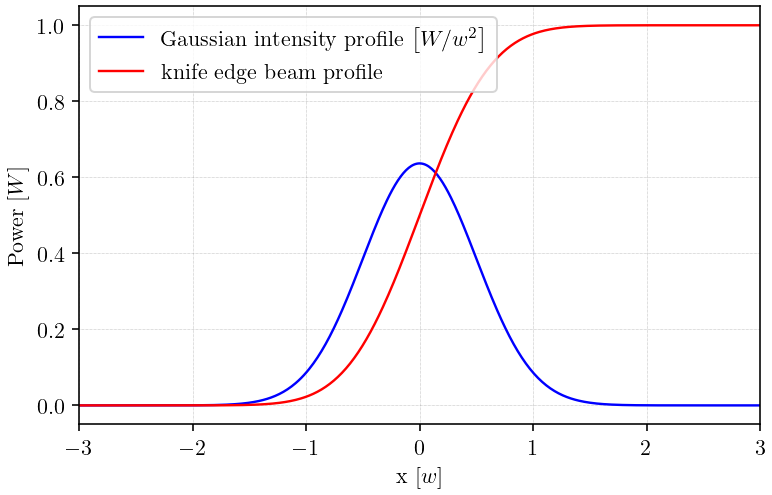

In [16]:
with mpf.style_context(['mpl_default', 'default', 'thesis']):
    fig, ax = plt.subplots()
    plt.plot(xs/w, np.squeeze(Im_00(xs,0,w)), label=r'Gaussian intensity profile $\left[ W/w^2 \right]$')
    plt.plot(xs/w, Im_erf(xs,w), label='knife edge beam profile')
    plt.xlabel(r'x $[w]$')
    plt.ylabel(r'Power $\left[ W \right]$')
    plt.legend()
   
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    
    plt.grid(True, which='both', axis='y')

    mpf.thesis_savefig(fig, cwd / 'knife_edge_profile')
    plt.show()

In [17]:
def Im_erf_inv(g,a):
    wx = np.sqrt(2)*a/scipy.special.erfinv(-1+2*g)
    return wx

def Im_erf_inv2(x):
    x = np.atleast_2d(x)
    wx = np.sqrt(2)/scipy.special.erfinv(-1+2*x[0,:])
    return wx

def knife_edge_rule_conversion_factor(rule=0.9, twosided=True):
    '''
    Computes the conversion from knife edge beam width to 1/e width for an arbitrary rule.
    By default the conversion factor is for the 10:90 knife edge rule.
    '''
    rule = np.asarray(rule).copy()
    rule[rule <= 0] = 0
    rule[rule >= 1] = 1
    conversion = np.sqrt(2)/scipy.special.erfinv(-1+2*rule)
    if twosided:
        conversion = conversion/2
    return conversion

In [18]:
rule = np.random.rand()
w_onesided = np.abs(xs[nf.find_nearest_ind(Im_erf(xs,w), rule)]) * knife_edge_rule_conversion_factor(rule, twosided=False)

rule = np.random.rand()
if rule > 0.5:
    rule = 1.0 - rule
xl = xs[nf.find_nearest_ind(Im_erf(xs,w), rule)]
xu = xs[nf.find_nearest_ind(Im_erf(xs,w), 1-rule)]
w_twosided = (xu-xl) * knife_edge_rule_conversion_factor(rule, twosided=True)

print(f'{rule = }')
print(f'true     w {w}')
print(f'onesided w {w_onesided}')
print(f'twosided w {w_twosided}')

rule = 0.19042431846583852
true     w 1.0
onesided w -1.0059632894361776
twosided w -1.0133125956776332


In [19]:
gs = np.linspace(0.6,0.98,900)
# gs = np.linspace(0.5,1.0,1500)[1:-1]

out = []
ss = []
sm = []
var = 1e-6
N_eta = 3000
for g in gs:
    r = np.random.randn(N_eta)*var
    wr = np.std(scipy.special.erfinv(2*(g+r)-1))/(scipy.special.erfinv(2*(g)-1)) / var
    wr = np.mean(Im_erf_inv(g+r,1))/np.std(Im_erf_inv(g+r,1)) * var
    wr = np.std(1/(scipy.special.erfinv(2*(g+r)-1))) / (1/(scipy.special.erfinv(2*(g)-1)))/var
    out.append(wr)
out = np.array(out)

In [20]:
e = scipy.special.erfinv(2*gs-1) 
d = np.exp(e**2)/e**2 * np.sqrt(2*np.pi)
f = np.sqrt(2)/e
atf = np.exp(e**2)/e*np.sqrt(np.pi)

optimal_rule = 1/2*(1+scipy.special.erf(1/np.sqrt(2)))

In [21]:
def knife_edge_rule_NSR(r):
    e = scipy.special.erfinv(2*r-1) 
    d = np.exp(e**2)/e**2 * np.sqrt(2*np.pi)
    f = np.sqrt(2)/e
    atf = np.exp(e**2)/e*np.sqrt(np.pi)
    return atf

In [22]:
plt.plot(gs,out)
plt.plot(gs,knife_edge_rule_NSR(gs))
plt.axvline(optimal_rule, c='k', ls='--')

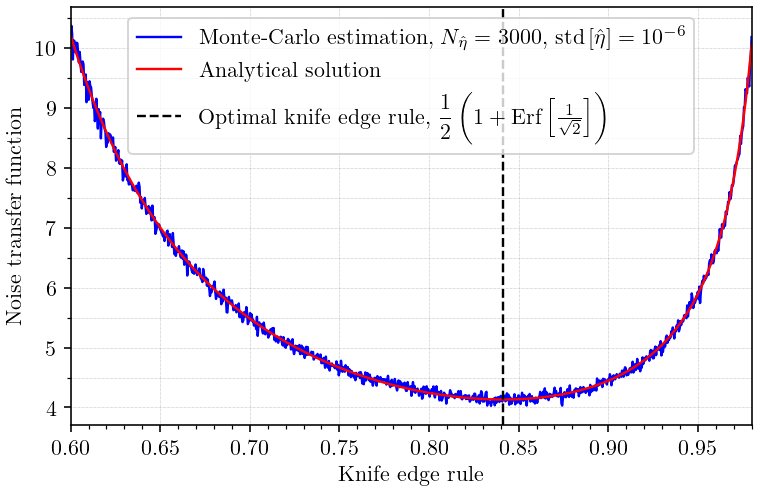

/home/alexei/git/alexei_thesis/notebooks/beam_profiling/knife_edge_noise_transfer_function.png
/home/alexei/git/alexei_thesis/notebooks/beam_profiling/knife_edge_noise_transfer_function.pdf


In [23]:
with mpf.style_context(['mpl_default', 'default', 'thesis']):
    fig, ax = plt.subplots()
    plt.plot(gs, out, label=r'Monte-Carlo estimation, $N_{\hat{\eta}} = 3000$, $\text{std} \left[ \hat{ \eta} \right] = 10^{-6}$')
    plt.plot(gs, np.exp(e**2)/e*np.sqrt(np.pi), label='Analytical solution')
    plt.axvline(optimal_rule, c='k', ls='--', label=r'Optimal knife edge rule, $\dfrac{1}{2} \left(1 + \text{Erf}\left[\frac{1}{\sqrt{2}}\right] \right)$')
    plt.ylabel('Noise transfer function')
    plt.xlabel('Knife edge rule')
   
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    
    plt.grid(True, which='both', axis='y')
    plt.legend()
    plt.show()

    mpf.thesis_savefig(fig, cwd / 'knife_edge_noise_transfer_function')

In [24]:
def knife_edge_beam_profile(xs, x0=0, w=1, a=1):
    '''
    Knife edge beam profile for a normalized u00 beam with knife edge 
    translating across x axis.
    '''
    return a * 1/2 * (1 + scipy.special.erf(np.sqrt(2)*(xs-x0)/w))